In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [125]:
# Load data from five data sets
list = ["SI", "QN", "MN", "BX", "BK"]
nydata = []
for i in list:
    url = "PLUTO17v1.1/" + i +"2017V11.csv"
    nydata.append(pd.read_csv(url))
nydata = pd.concat(nydata)

C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,24,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\fanfan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  i

In [126]:
'''
The objective of second EDA is to examine whether the total value of lot "AssessTot" (land and building) differs among boroughs
For this EDA, only residential lots are focused. According to data dictionary, lots with "BldgClass" in the following categoris
are residential lots: A: One family dwellings, B: Two family dwellings, C: Walk up apartments, D: Elevator apartment, 
R: Condominums, S: Residence are selected for analysis.
'''
import re

# Define regular expression to find pattern match for strings in the "BldgClass" column
p = re.compile('^[ABCDRS]+')
res_list = nydata["BldgClass"].str.contains(p)

# Only select the residential lots 
nydata = nydata[res_list==True]

In [128]:
# Define the empirical cumulative distribution function called ecdf
def ecdf(series):
    n = len(series)
    x = np.sort(series)
    y = np.arange(1, n+1)/n
    return x, y

In [130]:
# Find the 2.5 percentile and 97.5 percentile of the "AssessTot" to remove the 5% extreme values
np.percentile(nydata["AssessTot"], [2.5, 97.5])
nydata_inlier = nydata[(nydata["AssessTot"] > 12185) & (nydata["AssessTot"] < 1116450)]

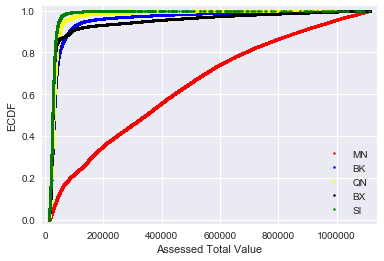

In [131]:
# First, I would like to do exploratory analysis to test whether the "AssessTot" differs across boroughs in New York City.
# There are five boroughs: Manhattan (MN), Brooklyn (BK), Queens (QN), Bronx (BX), Staten Island (SI)
nydata.Borough.value_counts()

# Plot the empirical cumulative distribution function of "AssessTot" for each borough
x_mn, y_mn = ecdf(nydata_inlier[nydata_inlier["Borough"]=="MN"].loc[:,"AssessTot"])
x_bk, y_bk = ecdf(nydata_inlier[nydata_inlier["Borough"]=="BK"].loc[:,"AssessTot"])
x_qn, y_qn = ecdf(nydata_inlier[nydata_inlier["Borough"]=="QN"].loc[:,"AssessTot"])
x_bx, y_bx = ecdf(nydata_inlier[nydata_inlier["Borough"]=="BX"].loc[:,"AssessTot"])
x_si, y_si = ecdf(nydata_inlier[nydata_inlier["Borough"]=="SI"].loc[:,"AssessTot"])

plt.plot(x_mn, y_mn, marker=".", linestyle="none", color="red", markersize=5, label="MN")
plt.plot(x_bk, y_bk, marker=".", linestyle="none", color="blue", markersize=5, label="BK")
plt.plot(x_qn, y_qn, marker=".", linestyle="none", color="yellow", markersize=5, label="QN")
plt.plot(x_bx, y_bx, marker=".", linestyle="none", color="black", markersize=5, label="BX")
plt.plot(x_si, y_si, marker=".", linestyle="none", color="green", markersize=5, label="SI")
plt.margins(0.02)
plt.xlabel("Assessed Total Value")
plt.ylabel("ECDF")
plt.legend()
plt.show()

# It can be seen that Manhattan is visually different from other boroughs

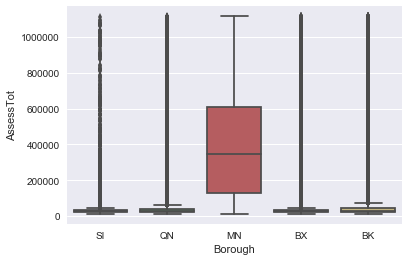

In [132]:
# This can also be seen from the boxplot that ""AssessTot"" of Manhatan is significantly different from others
sns.boxplot(x="Borough", y="AssessTot", data=nydata_inlier)
plt.show()

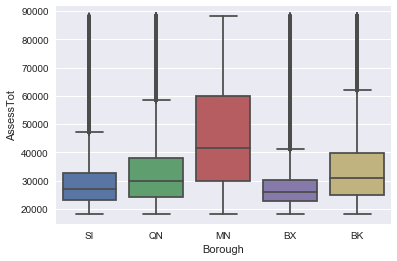

In [136]:
# Actually it is very hard to see the other boroughs as there still exist a lot of outliers
# Now I try to remove 20% of extreme values and give another try to the boxplot of "AssessTot"

np.percentile(nydata["AssessTot"], [10, 90])
nydata_inlier_20 = nydata[(nydata["AssessTot"] > 18288) & (nydata["AssessTot"] < 88124)]

# Plot the resultant boxplot, now the shape of boxplot for other boroughs become more clear
sns.boxplot(x="Borough", y="AssessTot", data=nydata_inlier_20)
plt.show()

In [137]:
# Now the four boroughs are compared. First one-way ANOVA is implemented to see whether "Borough" is an impact factor for "AssessTot"
import scipy.stats as stats
bk_f = nydata_inlier[nydata_inlier["Borough"]=="BK"]["AssessTot"]
qn_f = nydata_inlier[nydata_inlier["Borough"]=="QN"]["AssessTot"]
bx_f = nydata_inlier[nydata_inlier["Borough"]=="BX"]["AssessTot"]
si_f = nydata_inlier[nydata_inlier["Borough"]=="SI"]["AssessTot"]

f_val, p1 = stats.f_oneway(bk_f, qn_f, bx_f, si_f)
print ("ANOVA p value: %.10f" % p1)

# Since there are a lot of outliers, the results of ANOVA may be impacted. The median test is also conducted.
stat, p2, med, tbl = stats.median_test(bk_f, qn_f, bx_f, si_f)
print ("Median test p value: %.10f" % p2)

# Since p values are both 0, indicating the null hypothesis that there is no difference is rejected. There are statistically
# significant differents among mean and median of the four boroughs. 

ANOVA p value: 0.0000000000
Median test p value: 0.0000000000


In [190]:
'''Further bootstrap samples of each borough are created to generate bootstrap replicates (median) to compare medians of
four boroughs meanwhile reducing impacts of outliers and assumptions made in median test'''

# Define a function to generate n bootstrap replicates of median using 10000 random samples from original data
def bs_reps(data, func, n, size=10000):
    bs = np.empty(n)
    for i in range(n):
        bs[i] =  func(np.random.choice(data, size=10000))  # size could be set as len(data) or other number 
    return bs

# Calulate the bootstrap medians
bs_bk = bs_reps(bk_f, np.median, n=1000)
bs_qn = bs_reps(qn_f, np.median, n=1000)
bs_bx = bs_reps(bx_f, np.median, n=1000)
bs_si = bs_reps(si_f, np.median, n=1000)

In [191]:
# Plot the bee swarmplot to visually see how the boostrap median replicates differ across boroughs
d = {"BK": bs_bk, "QN": bs_qn, "BX":bs_bx, "SI": bs_si}
df = pd.DataFrame(data=d)
df_all = pd.melt(df, value_vars=["BK","BX","QN","SI"], var_name="Borough", value_name="Median")

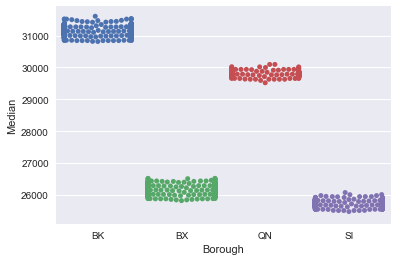

In [144]:
sns.swarmplot(x="Borough", y="Median", data=df_all)
plt.show()

# it can be seen the results are compatible with the median test resutls, median of "AssessTot" differs across boroughs

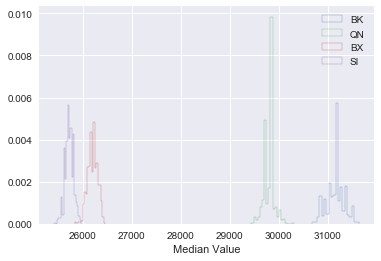

In [192]:
# Plot the distribution of boostrap median replicates 
plt.hist(bs_bk, normed = True, histtype = "step", facecolor="blue", bins=20)
plt.hist(bs_qn, normed = True, histtype = "step", facecolor="red", bins=20)
plt.hist(bs_bx, normed = True, histtype = "step", facecolor="orange", bins=20)
plt.hist(bs_si, normed = True, histtype = "step", facecolor="black", bins=20)

plt.legend(("BK", "QN", "BX", "SI"))
plt.xlabel("Median Value")
plt.show()

'''Again there indeed exsit significant differences of median of "AssessTot" across different boroughs.Different policies 
and programs might be necessary for different boroughs in terms of controlling the value of lot. In further analysis, how the 
geospatial profiles and characteristics of land and buildings impact the value of tax lot will be quantitatively explored. '''